<a href="https://colab.research.google.com/github/owenshi2/CS466-project/blob/main/DeBruijn_Graph_Builder_Visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
!ls

sample_data


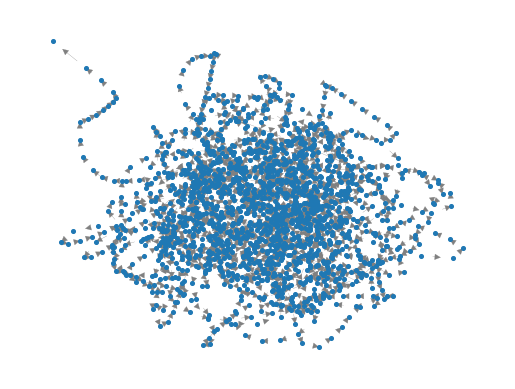

In [42]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

class DeBruijnSampler:
    def __init__(self, basePairs: list[str], coverage: float, l1: int, l2: int):
        self.basePairs = {bp : 0 for bp in basePairs}
        self.numBasePairs = 0

        self.genome = ""
        self.reads = {}

        self.l1, self.l2 = l1, l2
        self.coverage_limit = coverage

    def ReadData(self, fn):
        f = open(fn, "r")
        self.genome = f.read()
        f.close()

    def Sample(self):
        l = random.randint(self.l1, self.l2)
        loc = random.randint(0, len(self.genome) - l)
        return self.genome[loc:loc+l]

    def Process(self):
        while self.numBasePairs / len(self.genome) < self.coverage_limit:
            tmp = self.Sample()
            self.reads[tmp] = True
            for i in range(len(tmp) - 1):
                candidate = tmp[i] + tmp[i + 1]
                if candidate in self.basePairs:
                    self.basePairs[candidate] += 1
                    self.numBasePairs += 1

class DeBruijnGraph:
  """ A de Bruijn multigraph built from a collection of strings.
  User supplies strings and k-mer length k. Nodes of the de
  Bruijn graph are k-1-mers and edges join a left k-1-mer to a
  right k-1-mer. """

  @staticmethod
  def chop(st, k):
    """ Chop a string up into k mers of given length """
    for i in range(0, len(st)-(k-1)): yield st[i:i+k]

  class Node:
    """ Node in a de Bruijn graph, representing a k-1 mer """
    def __init__(self, km1mer):
      self.km1mer = km1mer

    def __hash__(self):
      return hash(self.km1mer)

  def __init__(self, strIter, k):
    """ Build de Bruijn multigraph given strings and k-mer length k """
    self.G = {} # multimap from nodes to neighbors
    self.nodes = {} # maps k-1-mers to Node objects
    self.k = k
    for st in strIter:
      for kmer in self.chop(st, k):
        km1L, km1R = kmer[:-1], kmer[1:]
        nodeL, nodeR = None, None
        if km1L in self.nodes:
          nodeL = self.nodes[km1L]
        else:
          nodeL = self.nodes[km1L] = self.Node(km1L)
        if km1R in self.nodes:
          nodeR = self.nodes[km1R]
        else:
          nodeR = self.nodes[km1R] = self.Node(km1R)
        self.G.setdefault(nodeL, []).append(nodeR)

class Driver:
    def __init__(self, fname, k, timed=False, labels=False):
      self.labels = labels
      self.bp = ["AT", "TA", "CG", "GC"]
      self.node_count = 0
      if timed:
        self.NoGraph(fname, k)
      else:
        self.Engine(fname, k)

    def Engine(self, fname, k):
        dbs = DeBruijnSampler(self.bp, 10, 30, 50)
        dbs.ReadData(fname)
        dbs.Process()
        self.GraphCode(dbs.reads, k)

    def NoGraph(self, fname, k):
      dbs2 = DeBruijnSampler(self.bp, 10, 30, 50)
      dbs2.ReadData(fname)
      dbs2.Process()
      self.GraphCodeNoShow(dbs2.reads, k)

    def visualize_graph(self, de_bruijn_graph):
      G = nx.DiGraph()

      for node in de_bruijn_graph.nodes.values():
          self.node_count += 1
          G.add_node(node.km1mer)
          if node in de_bruijn_graph.G:
              for neighbor in de_bruijn_graph.G[node]:
                  G.add_edge(node.km1mer, neighbor.km1mer)

      pos = nx.spring_layout(G)
      nx.draw_networkx_nodes(G, pos, node_size=7)
      nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', width=0.2)

      if self.labels:
          nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
      plt.axis('off')
      plt.show()

    def visualize_graph_noShow(self, de_bruijn_graph):
      G = nx.DiGraph()

      for node in de_bruijn_graph.nodes.values():
          self.node_count += 1
          G.add_node(node.km1mer)
          if node in de_bruijn_graph.G:
              for neighbor in de_bruijn_graph.G[node]:
                  G.add_edge(node.km1mer, neighbor.km1mer)

    def GraphCode(self, bpCount, k):
        strIter = [''.join([bp] * count) for bp, count in bpCount.items()]
        dbg = DeBruijnGraph(strIter, k)
        self.visualize_graph(dbg)
    def GraphCodeNoShow(self, bpCount, k):
        strIter = [''.join([bp] * count) for bp, count in bpCount.items()]
        dbg = DeBruijnGraph(strIter, k)
        self.visualize_graph_noShow(dbg)

d = Driver("sample_data/PorcineCircovirus2Genome.txt", k=10, timed=False)

# Graph Analysis


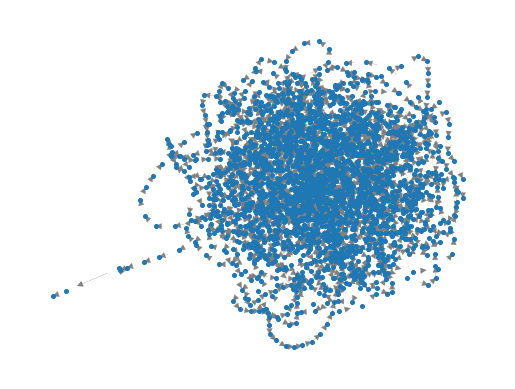

In [ ]:
import time
import math
def timekeep(func, fname, k, iterations):
  times = []
  for i in range(iterations):
    start_time = time.time()
    func(fname, k, True)
    end_time = time.time()
    times.append(end_time - start_time)
  avg_time = sum(times) / len(times)
  return avg_time

def aveNode(fname, k, iterations):
  nodes = []
  for i in range(iterations):
    print(i)
    nodes.append(Driver(fname, k, True).node_count)
  return sum(nodes)//len(nodes)

#Analysis of Number of Nodes
runAve = []
for i in range(3, 12):
  runAve.append(aveNode('sample_data/PorcineCircovirus2Genome.txt', i, 10))
for i in range(3, 12):
  runAve.append(aveNode('sample_data/genome1-short.txt', i, 10))
for i in range(3, 12):
  runAve.append(aveNode('sample_data/genome2-short.txt', i, 10))

d2 = Driver("sample_data/genome1-short.txt", k=10, timed=False)

# print(timekeep(Driver, 'sample_data/PorcineCircovirus2Genome.txt', 3, 100))
# print(timekeep(Driver, 'sample_data/PorcineCircovirus2Genome.txt', 5, 100))
# print(timekeep(Driver, 'sample_data/PorcineCircovirus2Genome.txt', 10, 100))
# print(timekeep(Driver, 'sample_data/PorcineCircovirus2Genome.txt', 25, 100))
# print(timekeep(Driver, 'sample_data/PorcineCircovirus2Genome.txt', 50, 100))
# print(timekeep(Driver, 'sample_data/PorcineCircovirus2Genome.txt', 100, 100))

d3 = Driver('sample_data/genome2-short.txt', k=10, timed=False)

d4 = Driver('sample_data/genome3-short.txt', k=10, timed=False)

# Try Perturbing k, and graph number of nodes vs k

In [ ]:
runAve

[16,
 64,
 254,
 769,
 1338,
 1626,
 1719,
 1749,
 1754,
 23,
 77,
 207,
 422,
 611,
 715,
 763,
 780,
 787]